### Example of a model with a compressible material

An instantaneous 2D extension model. A compressible material is subject to lateral extension boundary conditions along the vertical walls.

The compressible stokes flow equations are based on the compressible elasticity formulation: see Hughes, sec4.3, The Finite Element Method, 1987

-----
The momentum equtaion

$
    \sigma_{i,j} = -\mathbf{p}\delta_{i,j} + 2 \eta \dot\epsilon_{i,j} = f_{i}
$

The continuity equation

$
    \mathbf{v}_{i,i} + \frac{\mathbf{p}}{\lambda} = 0
$ 
where:
 * $ \dot \epsilon_{i,j} = \frac{1}{2}\left[ \mathbf{v}_{i,j} + \mathbf{v}_{j,i} \right ]$
 * $\mathbf{v}$ is the velocity field
 * $\mathbf{p}$ is the pressure like variable
 * $\eta$ is the isotropic shear viscosity
 * $\lambda$ is the bulk viscosity
 * $f$ is the body force

In [1]:
import underworld as uw
import numpy as np
import math
import os
from underworld import function as fn
import glucifer

In [2]:
minX = 0.0
maxX = 2.0
maxY = 1.0
resX = 64
resY = 32
elementType="Q1/dQ0"

mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = ( resX, resY), 
                                 minCoord    = ( minX, 0.), 
                                 maxCoord    = ( maxX, maxY),
                                 periodic    = [False, False]  ) 

vField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pField = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

vField.data[:] = [0.,0.]
pField.data[:] = 0.

In [3]:
# model parameters
viscosityFn   = 1.0        # isoviscous
vel_extend    = 0.5        # simple extension velocity
oneonlambdaFn = 1.0e3      # 1/(bulk viscosity)
buoyancyFn = ( 0.0, 0.0 )  # the body force

In [4]:
# first define strain rate tensor
strainRateFn = fn.tensor.symmetric( vField.fn_gradient )
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateFn)
velmag = fn.math.sqrt( fn.math.dot(vField, vField) )

In [5]:
leftWall  = mesh.specialSets["MinI_VertexSet"]
rightWall = mesh.specialSets["MaxI_VertexSet"]

bottomWall = mesh.specialSets["MinJ_VertexSet"]
topWall    = mesh.specialSets["MaxJ_VertexSet"]

iWalls = leftWall + rightWall
jWalls = bottomWall + topWall

In [6]:
def buildVelocityField( mesh, velField, extV ):
    '''
    Build the extension velocity field. Only extending the incomp beam.
    '''
    import math
    # set the all nodes on the vertical wall to extend extension
    for index in leftWall: # velocity to the left
        ycoord = mesh.data[index][1]
        velField.data[index] = [-1.0*extV, 0.]
#         velField.data[index] = [-1.0*extV*math.sin(ycoord*2*math.pi), 0.]
    for index in rightWall: # velocity to the right
        ycoord = mesh.data[index][1]
        velField.data[index] = [extV, 0.]

buildVelocityField( mesh, vField, vel_extend)
bcs_1 = uw.conditions.DirichletCondition( variable        = vField, 
                                        indexSetsPerDof = ( iWalls, jWalls) ) 

In [7]:
# fn_bodyforce is 0. So ONLY dynamic pressure is produced in this model.
# For the incompressible material d. pressure is the mesh variable
# For the compressibly material d. pressure is -lambda*div(vField)
stokes = uw.systems.Stokes(    velocityField = vField, 
                               pressureField = pField, 
                               conditions    = bcs_1,
                               fn_viscosity  = viscosityFn,
                               fn_bodyforce  = buoyancyFn,
                               fn_one_on_lambda  = oneonlambdaFn )

solver = uw.systems.Solver( stokes )

In [8]:
# can't use the AugmentedLagrangian with the penaly method yet
# solver.set_penalty(1.0e6) 
solver.solve( nonLinearIterate=False, nonLinearTolerance=1e-2 )
# solver.print_stats()

In [9]:
# analytics
gradV = vField.fn_gradient
divV = gradV[0] + gradV[3] # du_dx + dv_dy
shouldBeZero = fn.math.abs(divV + pField*oneonlambdaFn)

errorInt = uw.utils.Integral( shouldBeZero, mesh)
volInt = uw.utils.Integral(1.0, mesh)

In [10]:
# error across domain
tol = 1e-6
error = errorInt.evaluate()[0]/volInt.evaluate()[0]
if error > tol:
    raise RuntimeError("Error: The continuity equation isn't solving within a volume averaged" +
                       " tolerance of {} - it's value is {}".format(tol, error))
print(error)

3.52124312125e-15


In [11]:
stokes.eqResiduals

(1.1477448914757307e-14, 1.6428302536547724e-16)


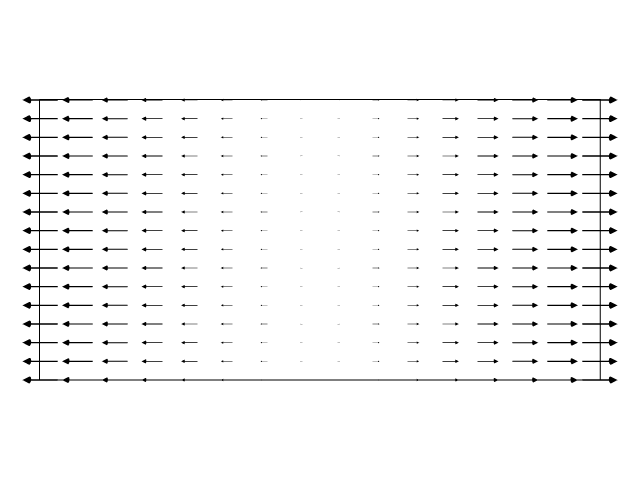

In [12]:
figVel = glucifer.Figure()
figVel.append( glucifer.objects.VectorArrows(mesh, vField, scaling=.25, arrowHead=0.2) )
figVel.show()

In [13]:
# # The pressure using the compute field
# figP = glucifer.Figure( **figVel )
# figP.append( glucifer.objects.Surface(mesh, pField*oneonlambdaFn, onMesh=True) )
# figP.show()